In [156]:
import pandas as pd
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style('darkgrid')
from collections import Counter
from numpy import argmax
import time

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Feature Selection
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

# Modeling
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score



In [ ]:
!pwd

Datasets:
* Dataset pre-processed: ./Data/df_preprocess_done.csv
* Dataset for prediction: ./Data/df_prediction.csv'

In [ ]:
df = pd.read_csv('./Data/df_preprocess_done.csv', index_col=0)
print("Size of the dataset:  %d" % df.shape[0])
print("Number of variables: %d" % df.shape[1])
df.head()

# 4. Modeling

1. Separate dataset 
    - For X and y classes. 
    - Split dataset for training and testing.
2. Feature Selection
    - Use linear regression model
    - Use ...
3. Modeling for finding the best:
    - Model creation with pipeline
    - GridSearchCV for finding the best parameters of each model
    - Model Calibration using best parameters



In [ ]:
clf_stats_df = pd.DataFrame(columns=["clf_name", "F1-score", "auc-score", "elapsed_time"])

## 1. Separate dataset for X and y classes.

In [ ]:
X = df.drop('churn', axis = 1)
y = df['churn']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

In [ ]:
x_train.columns, y_train.name

## 2. Feature Selection

### 2.1. Using Linear Regression Model

In [ ]:
log_rg = LogisticRegression().fit(x_train, y_train)

feature_importance_lr = pd.DataFrame(zip(x_train.columns.values, log_rg.coef_.ravel()))
feature_importance_lr.columns = ['feature', 'coef']
feature_importance_lr.sort_values("coef", ascending=False, inplace=True)
plt.bar(feature_importance_lr['feature'], feature_importance_lr['coef'])
plt.xticks(rotation=90, fontsize=9)

In [ ]:
feature_importance_lr.where((feature_importance_lr["coef"] < -0.1)|(feature_importance_lr["coef"] > 0.1)).dropna()

In [ ]:
feature_logistic = list(feature_importance_lr.where((feature_importance_lr["coef"] < -0.1)|(feature_importance_lr["coef"] > 0.1)).dropna()['feature'].values)
print("More important features with coef < -0.1 and coef > 0.1: \n", "There is a {} features from {}".format(len(feature_logistic), x_train.shape[1]) )
feature_logistic

Using this model, the more important features with coef < -0.1 and coef > 0.1. There is a 12 features from 28. We can see that the more important variables are:

- 'payment_type_Weekly',
- 'web_user',
- 'zodiac_sign_Capricorn',
- 'cc_application_begin',
- 'housing_R',
- 'age',
- 'zodiac_sign_Aquarius',
- 'zodiac_sign_Libra',
- 'zodiac_sign_Taurus',
- 'housing_O',
- 'reward_rate',
- 'purchases_partners'

In [ ]:
lr_support_num = feature_importance_lr["coef"].values
lr_support = np.where((lr_support_num > 0.1)|(lr_support_num < -0.1), True, False)
lr_support

As a number of features, we will calculate the best 12 features using other methods. Later, we will sum up and then calculate the most importants.

In [ ]:
num_feats = 12

### 2.2. Using Recursive Feature Elimination (RFE) as wrapped method

In [ ]:
# Number of features as 12
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=12, step=10, verbose=5)
rfe_selector.fit(x_train, y_train)
rfe_support = rfe_selector.get_support()
feature_rfe = x_train.loc[:,rfe_support].columns.tolist()
print(str(len(feature_rfe)), 'selected features')
print(feature_rfe)

In [ ]:
feature_rfe

In [ ]:
rfe_support

### 2.3. Using Random Forest as embeded method

In [ ]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=12)
embeded_rf_selector.fit(x_train, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
feature_embeded_rf = x_train.loc[:,embeded_rf_support].columns.tolist()
print(str(len(feature_embeded_rf)), 'selected features')
feature_embeded_rf

In [ ]:
embeded_rf_support

### 2.4. Using mutual info classif as entropy method

In [ ]:
importances =  mutual_info_classif(x_train,y_train)
feature_mutual_importance = pd.Series(importances, index = x_train.columns)
feature_mutual_importance.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [ ]:
feature_mutual_importance.where(feature_mutual_importance > 0.0023).sort_values(ascending=False).dropna()

In [ ]:
feature_mutual = list(feature_mutual_importance.where(feature_mutual_importance > 0.0023).sort_values(ascending=False).dropna().index)
print("The more important features are: \n")
feature_mutual

In [ ]:
mutual_support = np.where(importances > 0.0023, True, False)
mutual_support

### 3.5. Sum up and putting all together

In [ ]:
# put all selection together
feature_selection_df = pd.DataFrame({'Feature':x_train.columns, 
                                     'Logistics':lr_support,
                                     'RFE':rfe_support,
                                     'Random Forest':embeded_rf_support, 'Mutual Classif':mutual_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)

# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
# feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(num_feats)

In [ ]:
new_num_features = list(feature_selection_df['Feature'][0:12].values)
print("Here the most important features we will use for modeling:\n")
new_num_features

In this way, we split again the dataset using new_num_features list

In [ ]:
X = X[new_num_features]
y = df['churn']
print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=10)
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

In [ ]:
x_train

## 3. Modeling for finding the best:

- Find the best hyperparmeters: GridSearchCV
- Time for execution
- Metrics: Accuracy, ...
- Graphics: Precall vs Precision, KS, Acumulative Gain, AUC, ROC
- Calibration: 

### 3.1. Logistic Regresion Model

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
#parameters['clas__C'] = [10e-3, 10e-2, 10e-1, 1, 10, 100, 1000]
parameters['C'] = np.logspace(-3,3,10) 
parameters['class_weight'] = [None, 'balanced']
parameters['penalty'] = ["l1","l2",'elasticnet']
parameters['solver'] = ['newton-cg', 'lbfgs', 'liblinear', 'sag']

GS = GridSearchCV(LogisticRegression(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS.fit(x_train, y_train)

In [ ]:
print("Best score: ", GS.best_score_)
print("Best Hyperparameters: ", GS.best_params_)

In [ ]:
logr_model = LogisticRegression(C=0.0046, class_weight=None, max_iter=10000, penalty='l2', random_state=0, solver='newton-cg')
logr_model.fit(x_train, y_train)

In [ ]:
logr_model.coef_

In [ ]:
logr_model.classes_

In [ ]:
coef = logr_model.coef_[0] 
x_values = x_train.values@coef

In [ ]:
def logistic(x):
    return 1/(1+np.exp(-x))

plt.scatter(x_values, logistic(x_values))

In [ ]:
# Evaluation Function definition

def evaluationMetricsGCV(x_test, y_test, model_fit):
    y_pred = model_fit.predict(x_test)
    y_prob = model_fit.predict_proba(x_test)
    Accuracy = accuracy_score(y_test, y_pred)
    Precision = precision_score(y_test, y_pred)
    Recall = recall_score(y_test, y_pred)  
    F1 = f1_score(y_test, y_pred)
    
    print("\n")
    print("Results: ")
    for i in ['Accuracy', 'Precision', 'Recall', 'F1']:
        print('{} {} {:.3f}'.format(5*str('+') ,i+' Score' , locals()[i]))
    print("\n")
    target_names = ['No churn', 'Churn']
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    print("{} AUC (Area under the ROC Curve) : {:.3f}\n".format(5*str('+'), roc_auc_score(y_test, y_pred)))
    print("\n")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    plt.title("Confusion Matrix")
    sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True, cmap=plt.cm.Blues)
    plt.ylabel('Real Values')
    plt.xlabel('Prediction');
    plt.gca().set_ylim(2.0, 0)
    plt.show()
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_roc_curve(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_ks_statistic(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_precision_recall(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_cumulative_gain(y_test, y_prob)
    
    sns.set(rc={'figure.figsize':(6,6)})
    skplt.metrics.plot_lift_curve(y_test, y_prob)
    

In [ ]:
evaluationMetricsGCV(x_test, y_test, logr_model)

In [ ]:
y_prob = logr_model.predict_proba(x_test)[:,1]

In [ ]:
y_prob[:10][:,1], y_prob[:10][:,0] 

In [ ]:
plt.plot(y_prob[:100][:,0])

In [ ]:
y_pred = y_prob >= 0.88
show_results(y_test, y_pred)

In [ ]:
y_pred

In [ ]:
# COMPLETAR

precision, recall, thresholds = precision_recall_curve(y, y_prob)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.plot(recall[2000],precision[2000], 'or'); # Umbral = 0.227, rojo
plt.plot(recall[3500],precision[3500], 'og'); # Umbral = 0.5, verde
plt.plot(recall[5000],precision[5000], 'ob'); # Umbral = 0.805, azul
plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [ ]:
argmax(fscore), thresholds

### 3.2. Decision Tree Model

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['max_depth'] = [i for i in range(1, 11)]
parameters['class_weight'] = [None, 'balanced']
parameters['max_features'] = [i for i in range(1, 8)]
parameters['min_samples_leaf'] = [i for i in range(1, 11)]

#
GS_tree = GridSearchCV(DecisionTreeClassifier(random_state = 1000), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5)
GS_tree.fit(x_train, y_train)


In [ ]:
print("Best score: ", GS_tree.best_score_)
print("Best Hyperparameters: ", GS_tree.best_params_)

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=6,max_features=6, min_samples_leaf=4, random_state = 1000);
dt_model.fit(x_train, y_train)

In [ ]:
evaluationMetricsGCV(x_test, y_test, dt_model)

In [ ]:
y_pred = y_prob >= 0.47
show_results(y_test, y_pred)

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fscore = (2 * precision * recall) / (precision + recall)
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
plt.plot(recall, precision, color='orange')
plt.plot(recall[ix],precision[ix], marker='o', color='black'); # mejor threshold


plt.xlabel('Recall')
plt.ylabel('Precision');

print("Umbrales considerados: \t\t", np.round(thresholds,4))
#print("Predicciones (valores únicos):  ", np.round(np.unique(y_prob),4))

In [ ]:
 thresholds

### 3.3. SVM Model

In [ ]:
# GridSearchCV for SVM

parameters = {}
parameters['C'] = [10e-2, 1, 100]
parameters['kernel'] = ['linear','poly', 'rbf']
parameters['gamma'] = np.arange(0.01, 0.4, 0.1)

  _warn_prf(average, modifier, msg_start, len(res
#
GS_SVM = GridSearchCV(SVC(random_state = 1000, probability=True), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, n_jobs=-1)
GS_SVM.fit(x_train, y_train)


In [ ]:
print("Best score: ", GS_SVM.best_score_)
print("Best Hyperparameters: ", GS_SVM.best_params_)

In [ ]:
svm_model = SVC(C=1, gamma = 0.21, kernel = 'rbf', random_state = 1000, probability=True);
svm_model.fit(x_train, y_train)

In [ ]:
evaluationMetricsGCV(x_test, y_test, svm_model)

### 3.4. Random Forest Model

Hyperparameters Tuning

1. Finding n_estimators and max_depth

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
#parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1100, 1000, 1100, 1200, 1300]
#parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [7, 8, 9, 10, 11, 12, 13, 14, 15, None]

#
GS_rf = GridSearchCV(RandomForestClassifier(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, verbose=1, n_jobs=-1)
GS_rf.fit(x_train, y_train)


In [ ]:
print("Best score: ", GS_rf.best_score_)
print("Best Hyperparameters: ", GS_rf.best_params_)

2. Finding n_estimators and max_depth

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
#parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [70,80,90,100]
#parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [10]

#
GS_rf = GridSearchCV(RandomForestClassifier(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, verbose=1, n_jobs=-1)
GS_rf.fit(x_train, y_train)

In [ ]:
print("Best score: ", GS_rf.best_score_)
print("Best Hyperparameters: ", GS_rf.best_params_)

3. Finding max_features and criterion

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['max_features'] = ['auto', 'sqrt', 'log2', None]
parameters['n_estimators'] = [90]
parameters['criterion'] = ['entropy', 'gini']
parameters['max_depth'] = [10]

#
GS_rf = GridSearchCV(RandomForestClassifier(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, verbose=1, n_jobs=-1)
GS_rf.fit(x_train, y_train)

In [ ]:
print("Best score: ", GS_rf.best_score_)
print("Best Hyperparameters: ", GS_rf.best_params_)

In [ ]:
rf_model = RandomForestClassifier(criterion = 'entropy', max_depth =10, max_features = 'log2', n_estimators = 90)
rf_model.fit(x_train, y_train)



Results: 
+++++ Accuracy Score 0.682
+++++ Precision Score 0.673
+++++ Recall Score 0.553
+++++ F1 Score 0.607


              precision    recall  f1-score   support

    No churn       0.69      0.79      0.73      3354
       Churn       0.67      0.55      0.61      2675

    accuracy                           0.68      6029
   macro avg       0.68      0.67      0.67      6029
weighted avg       0.68      0.68      0.68      6029

+++++ AUC (Area under the ROC Curve) : 0.669





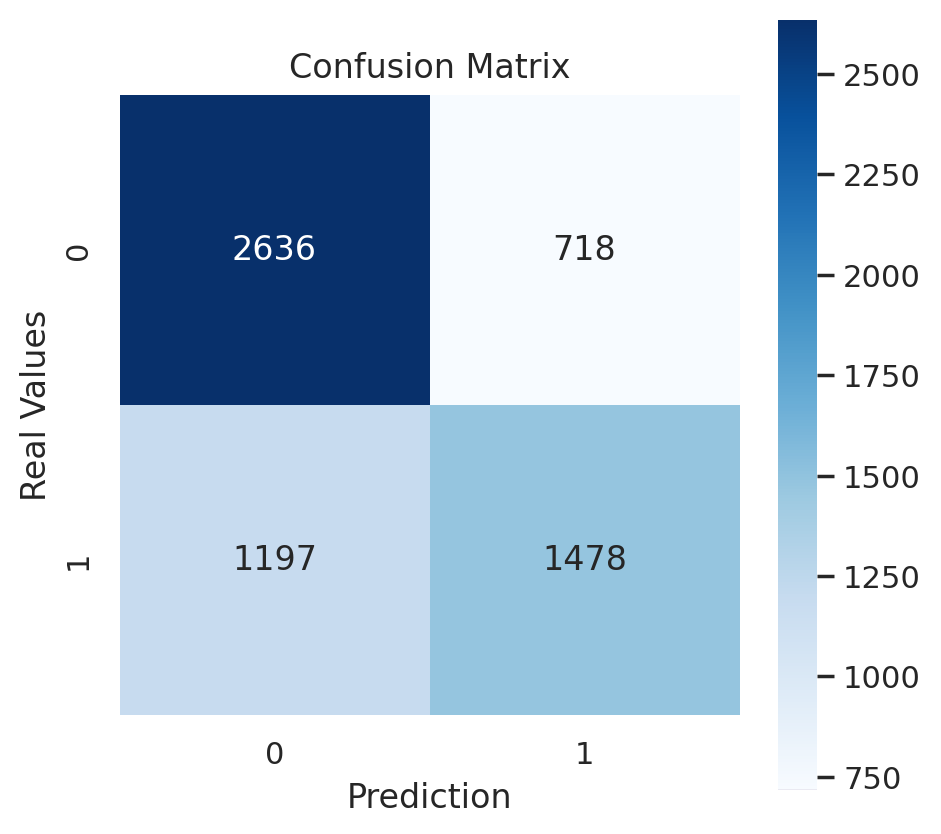

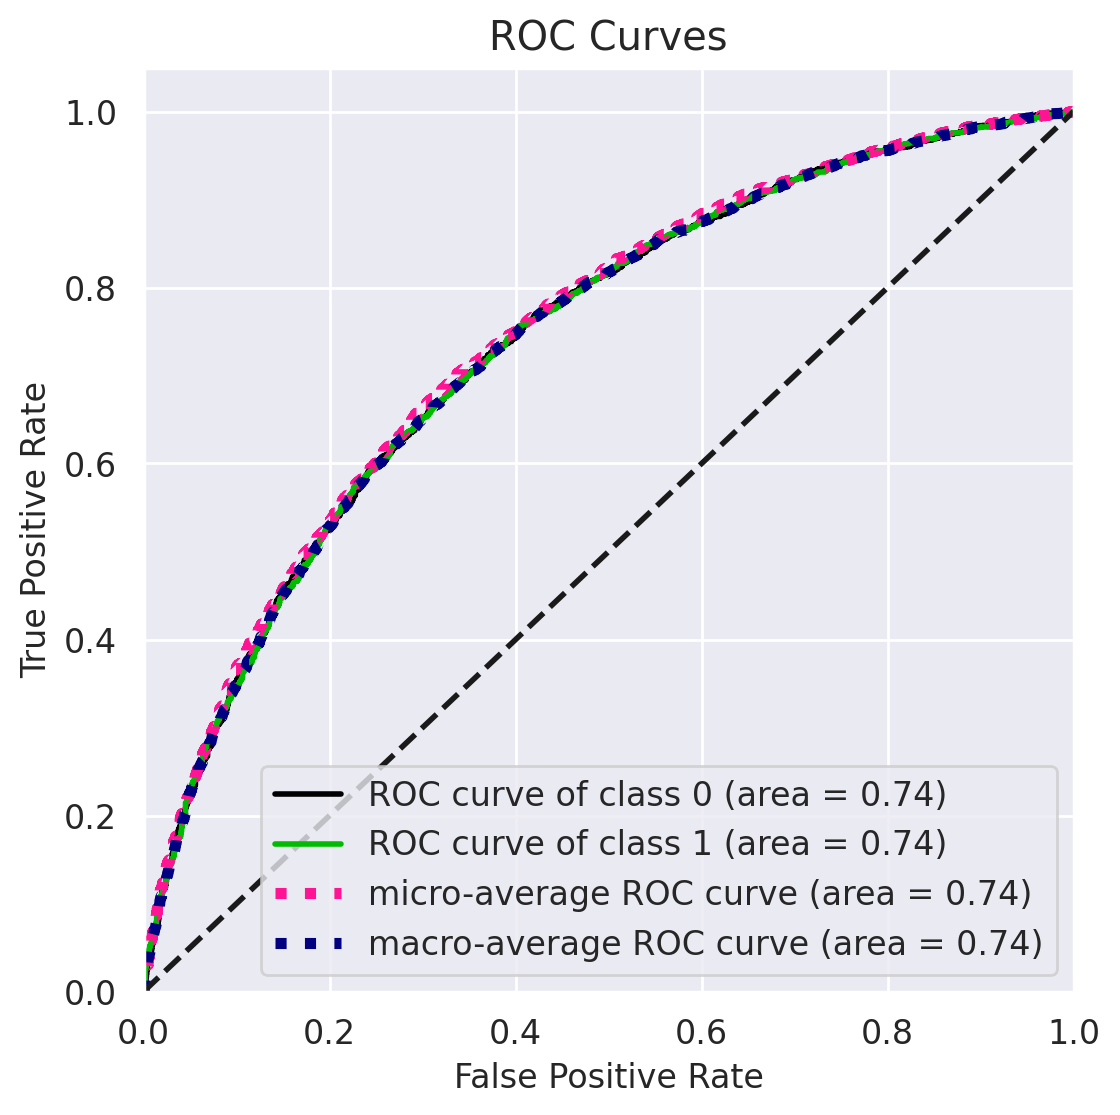

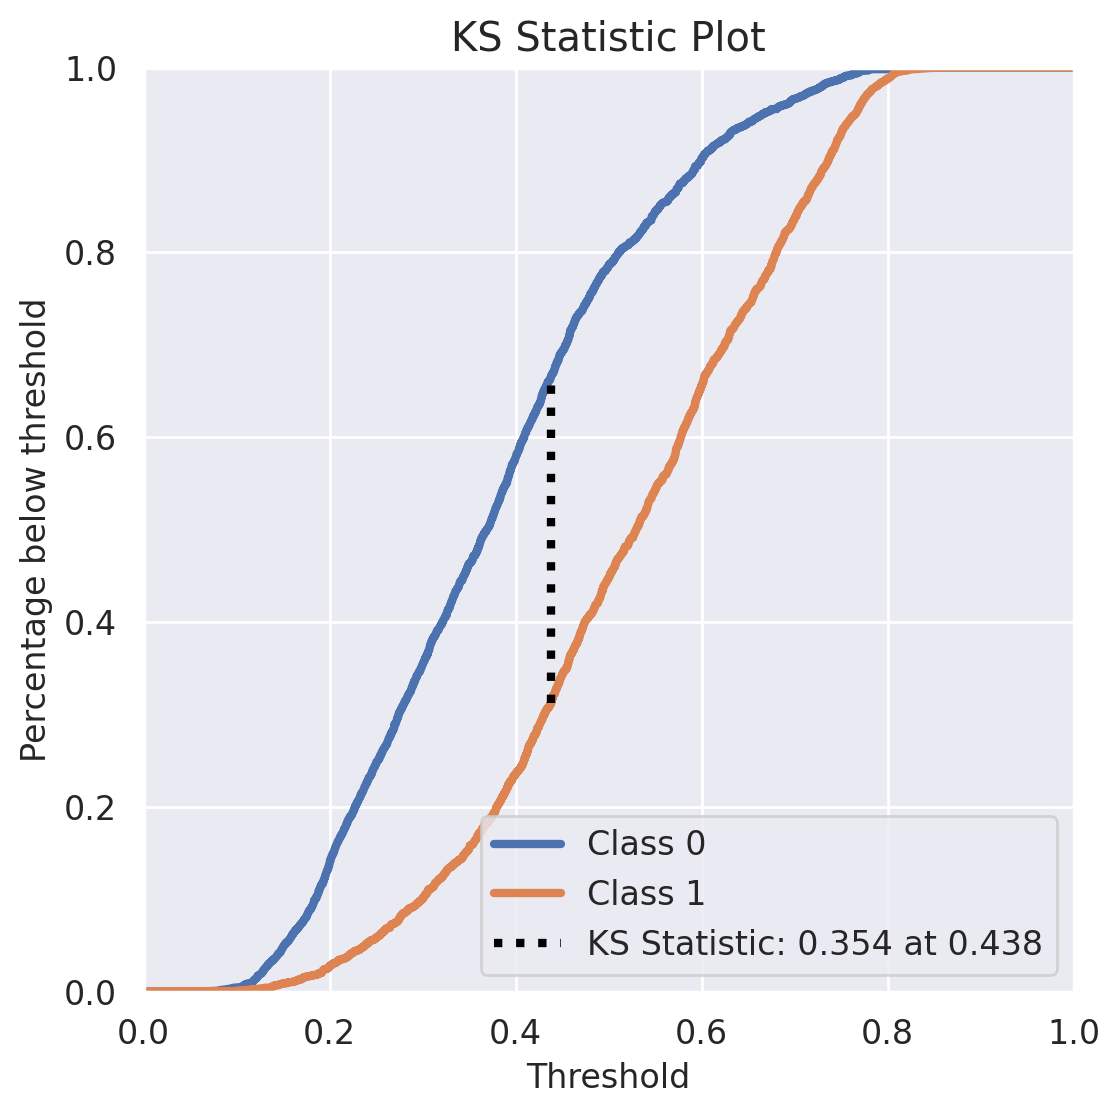

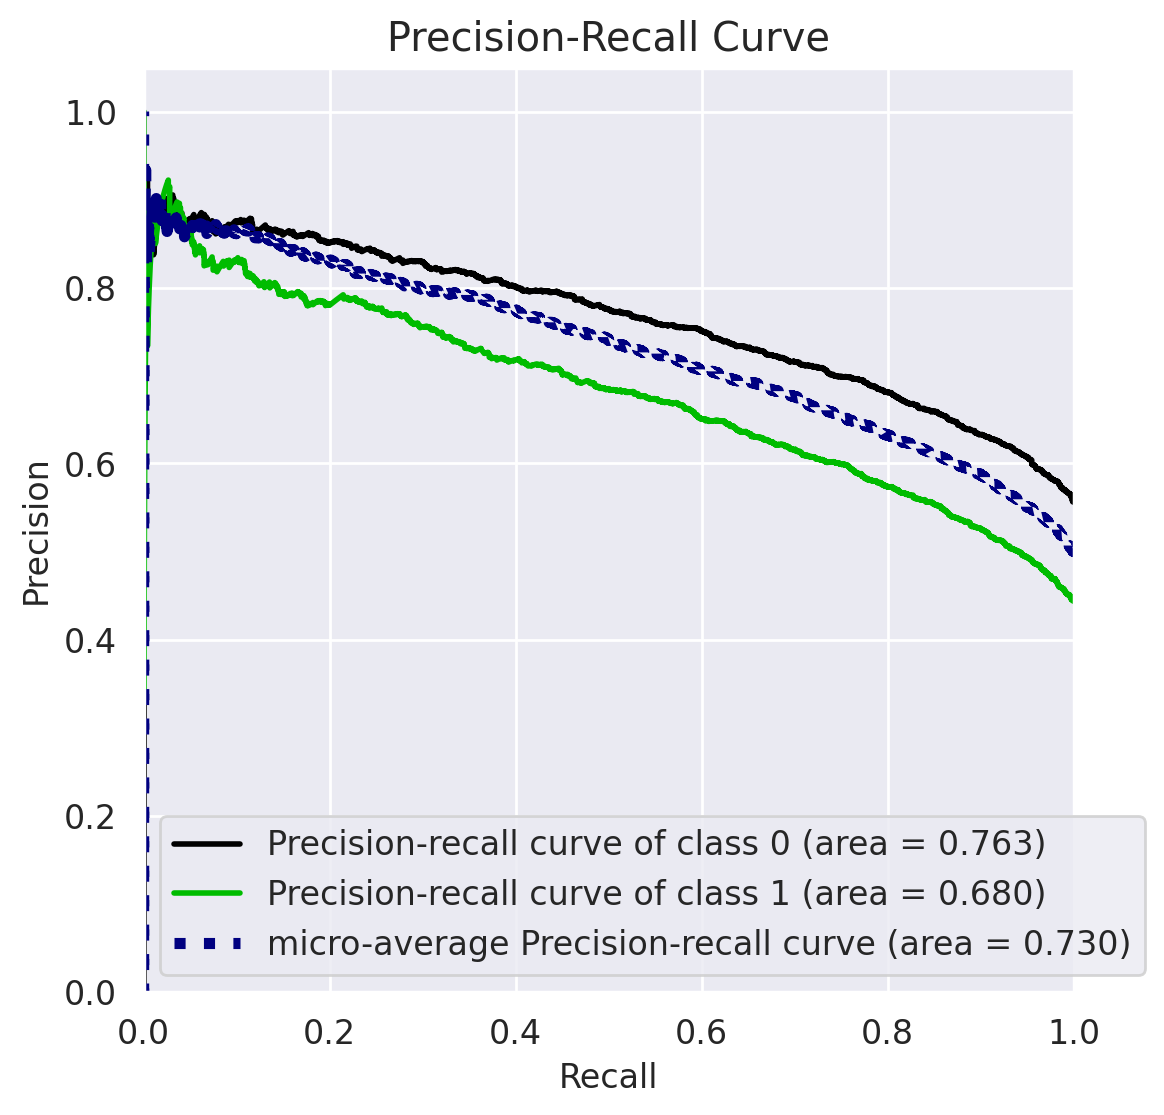

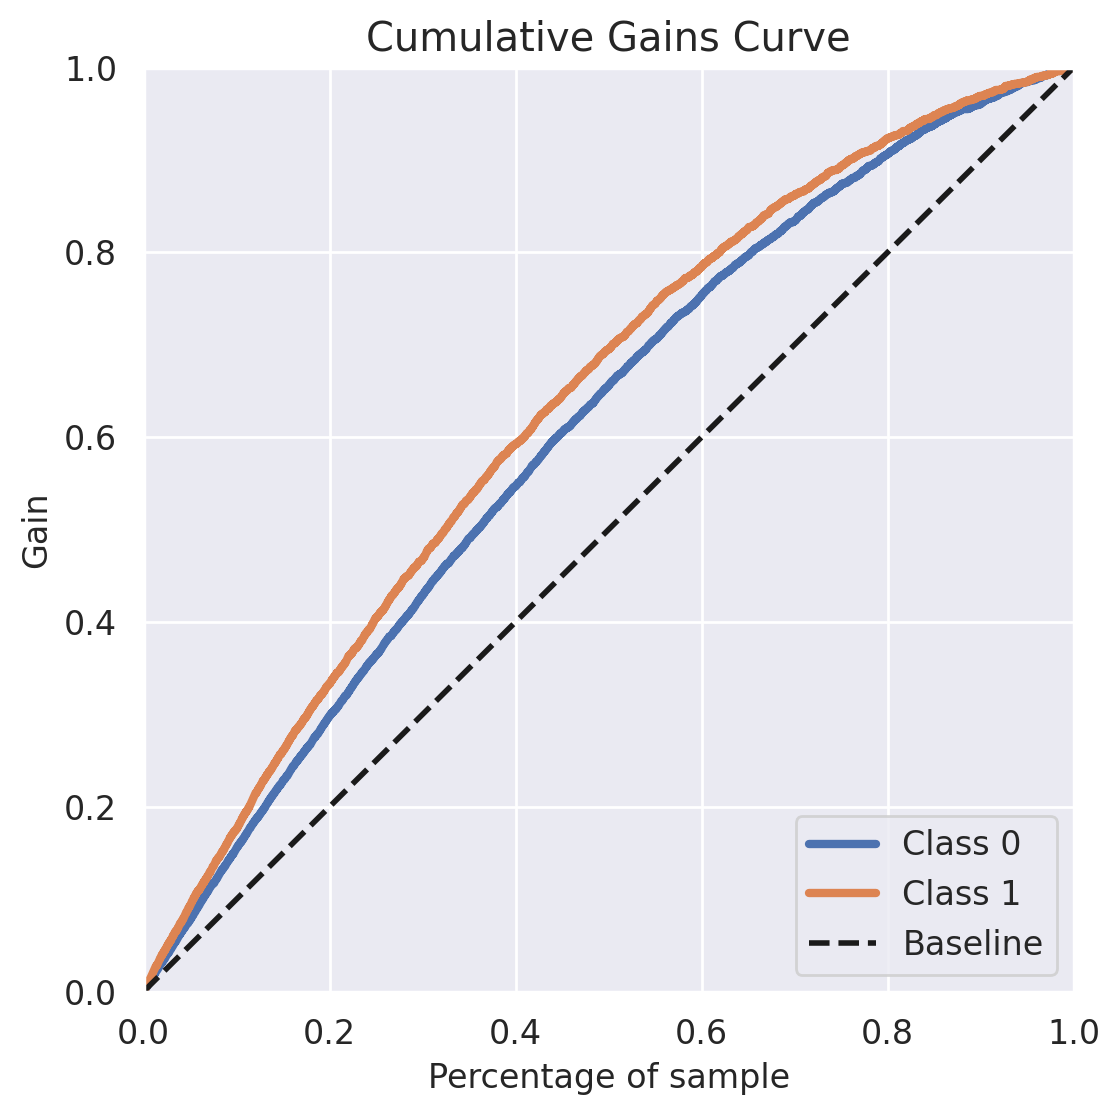

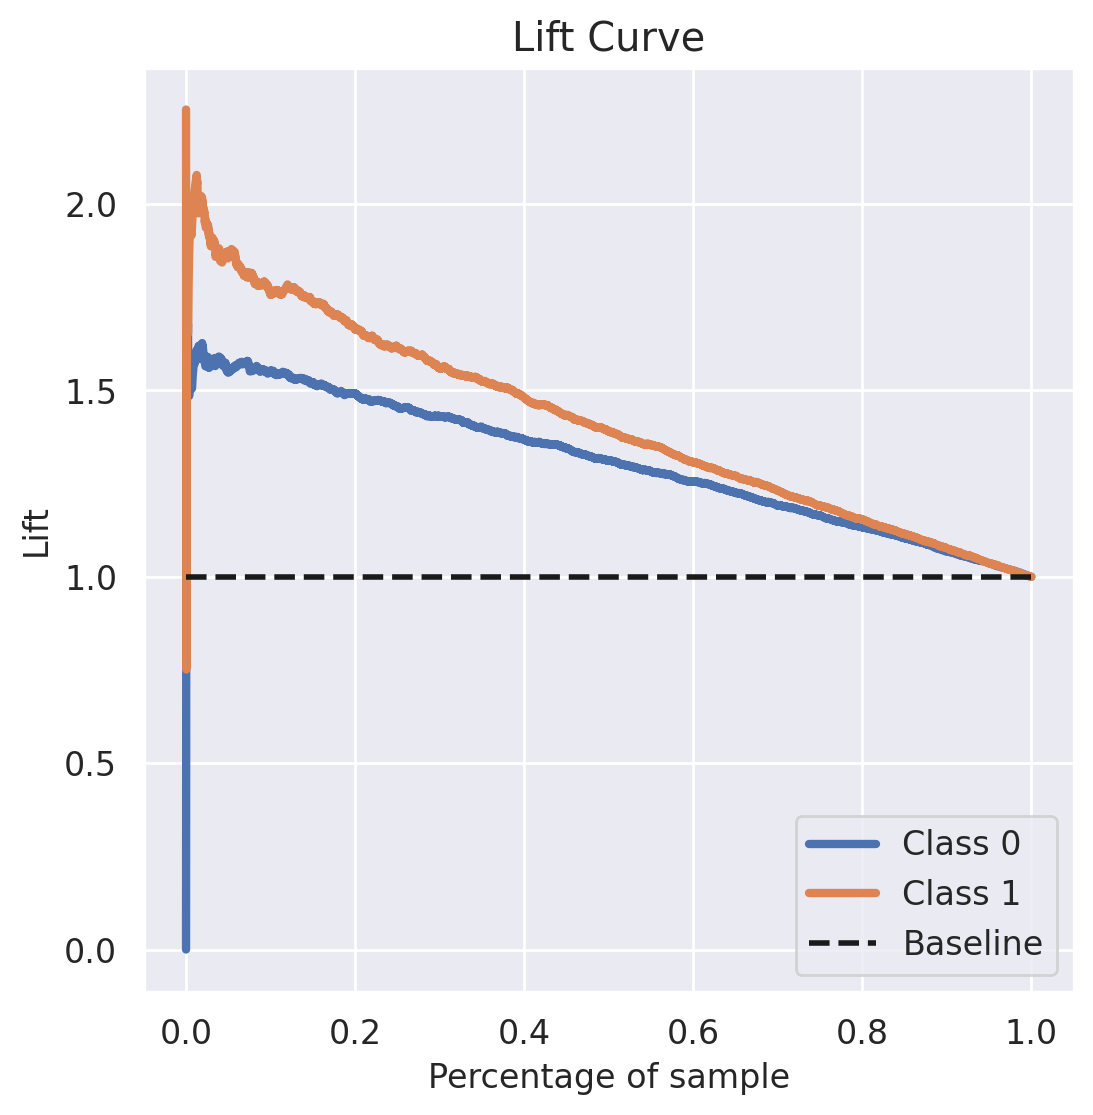

In [155]:
evaluationMetricsGCV(x_test, y_test, rf_model)

### 3.5. K Near Neighbor Model

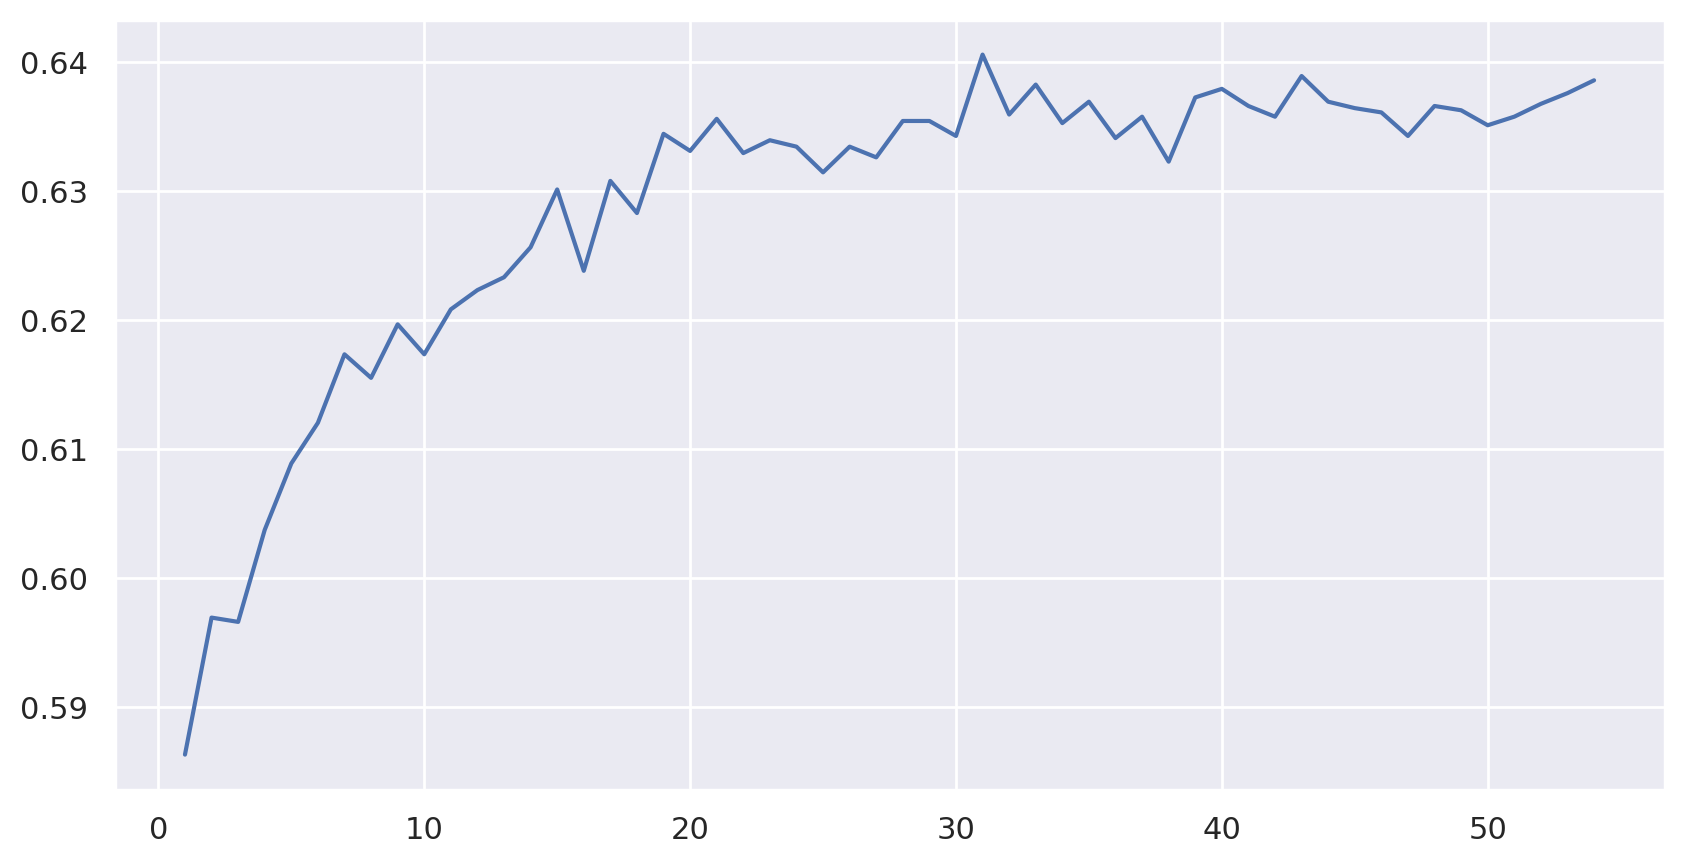

In [158]:
knn_scores = []
for i in range(1,55):
    knn = KNeighborsClassifier(n_neighbors  = i)
    knn.fit(x_train,y_train)
    knn_scores.append(knn.score(x_test,y_test))

plt.figure(figsize=(10,5))    
sns.lineplot(x = range(1,55), y = knn_scores)
plt.show()

In [ ]:
for idx, value in enumerate(knn_scores) :
    print(idx ,':', value)

0 : 0.5863327251617184
1 : 0.5969480842594128
2 : 0.5966163542876098
3 : 0.6037485486813734
4 : 0.6088903632443191
5 : 0.6120417979764472
6 : 0.6173494775252945
7 : 0.6155249626803782
8 : 0.619671587327915
9 : 0.6173494775252945
10 : 0.6208326422292254
11 : 0.6223254271023387
12 : 0.6233206170177475
13 : 0.6256427268203683
14 : 0.6301210814397081
15 : 0.623818211975452
16 : 0.630784541383314
17 : 0.6282965665947918
18 : 0.6344335710731465
19 : 0.6331066511859347
20 : 0.6355946259744568
21 : 0.6329407862000331
22 : 0.6339359761154421
23 : 0.6334383811577377
24 : 0.6314480013269199
25 : 0.6334383811577377
26 : 0.6326090562282303
27 : 0.6354287609885553
28 : 0.6354287609885553
29 : 0.634267706087245
30 : 0.6405705755515011
31 : 0.6359263559462598
32 : 0.6382484657488804
33 : 0.6352628960026538
34 : 0.6369215458616686
35 : 0.6341018411013435
36 : 0.6357604909603582
37 : 0.6322773262564273
38 : 0.6372532758334716
39 : 0.6379167357770774
40 : 0.6365898158898656
41 : 0.6357604909603582
42 : 0

In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['n_neighbors'] = [i for i in range(1,40)]
#parameters['weights'] = ['uniform', 'distance']
#parameters['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

#
GS_knn = GridSearchCV(KNeighborsClassifier(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, n_jobs=-1)
GS_knn.fit(x_train, y_train)

In [168]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [171]:
print("Best score: ", GS_knn.best_score_)
print("Best Hyperparameters: ", GS_knn.best_params_)

Best score:  0.6063205570941935
Best Hyperparameters:  {'n_neighbors': 12}


In [ ]:
# GridSearchCV for logistic Regression

parameters = {}
parameters['n_neighbors'] = [12]
parameters['weights'] = ['uniform', 'distance']
parameters['algorithm'] = ['auto', 'ball_tree', 'kd_tree', 'brute']

#
GS_knn = GridSearchCV(KNeighborsClassifier(), parameters , scoring = ['accuracy', 'precision', 'recall'], refit='precision', cv = 5, n_jobs=-1)
GS_knn.fit(x_train, y_train)

In [173]:
print("Best score: ", GS_knn.best_score_)
print("Best Hyperparameters: ", GS_knn.best_params_)

Best score:  0.6063205570941935
Best Hyperparameters:  {'algorithm': 'auto', 'n_neighbors': 12, 'weights': 'uniform'}


In [174]:
knn_model = KNeighborsClassifier(algorithm='auto', n_neighbors = 12, weights = 'uniform')
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=12)



Results: 
+++++ Accuracy Score 0.622
+++++ Precision Score 0.606
+++++ Recall Score 0.426
+++++ F1 Score 0.500


              precision    recall  f1-score   support

    No churn       0.63      0.78      0.70      3354
       Churn       0.61      0.43      0.50      2675

    accuracy                           0.62      6029
   macro avg       0.62      0.60      0.60      6029
weighted avg       0.62      0.62      0.61      6029

+++++ AUC (Area under the ROC Curve) : 0.602





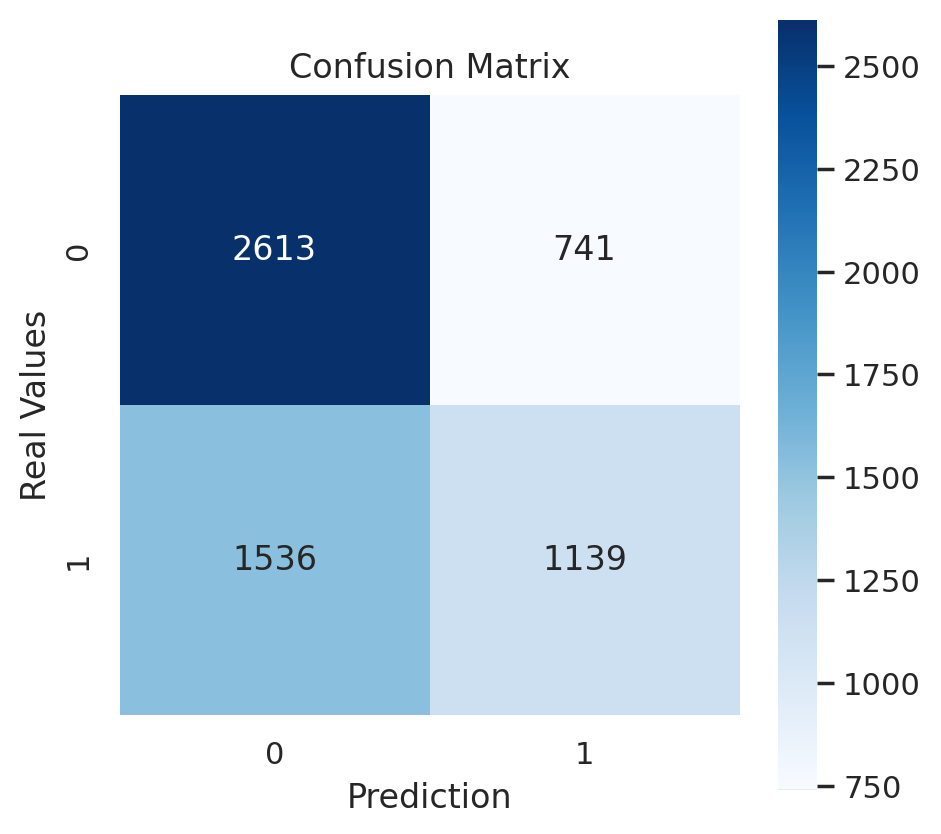

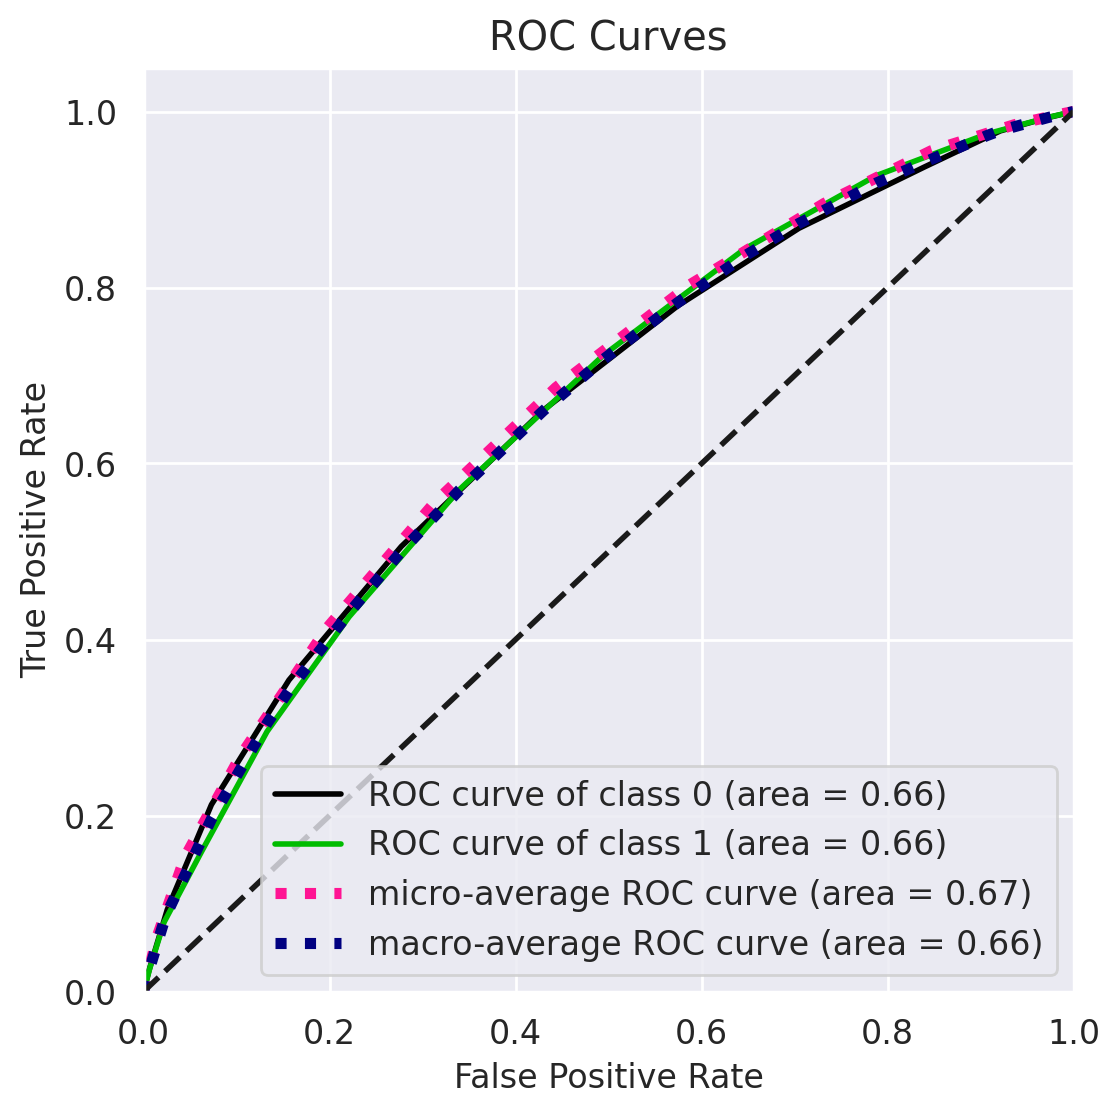

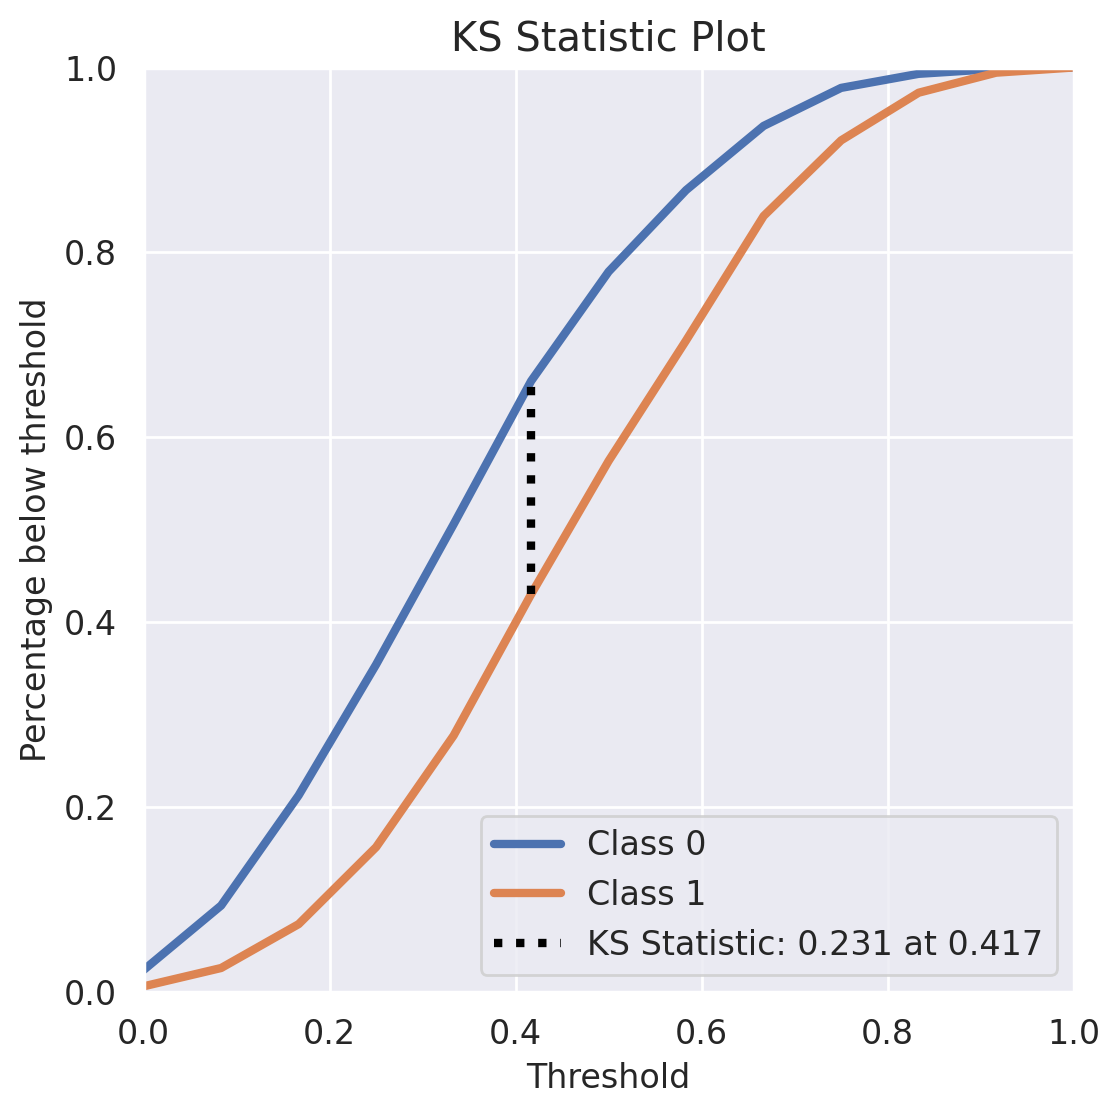

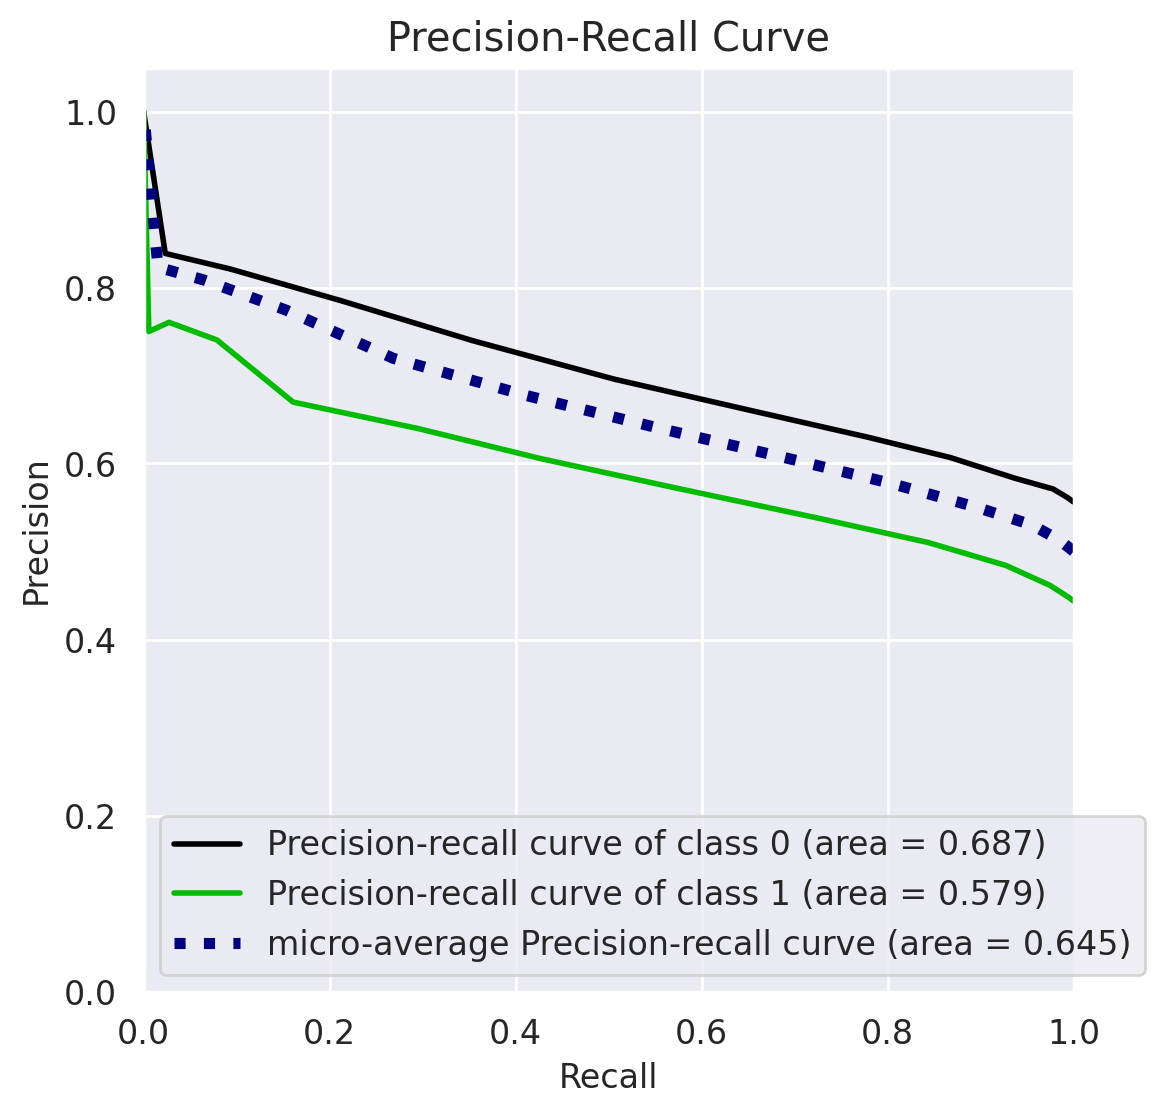

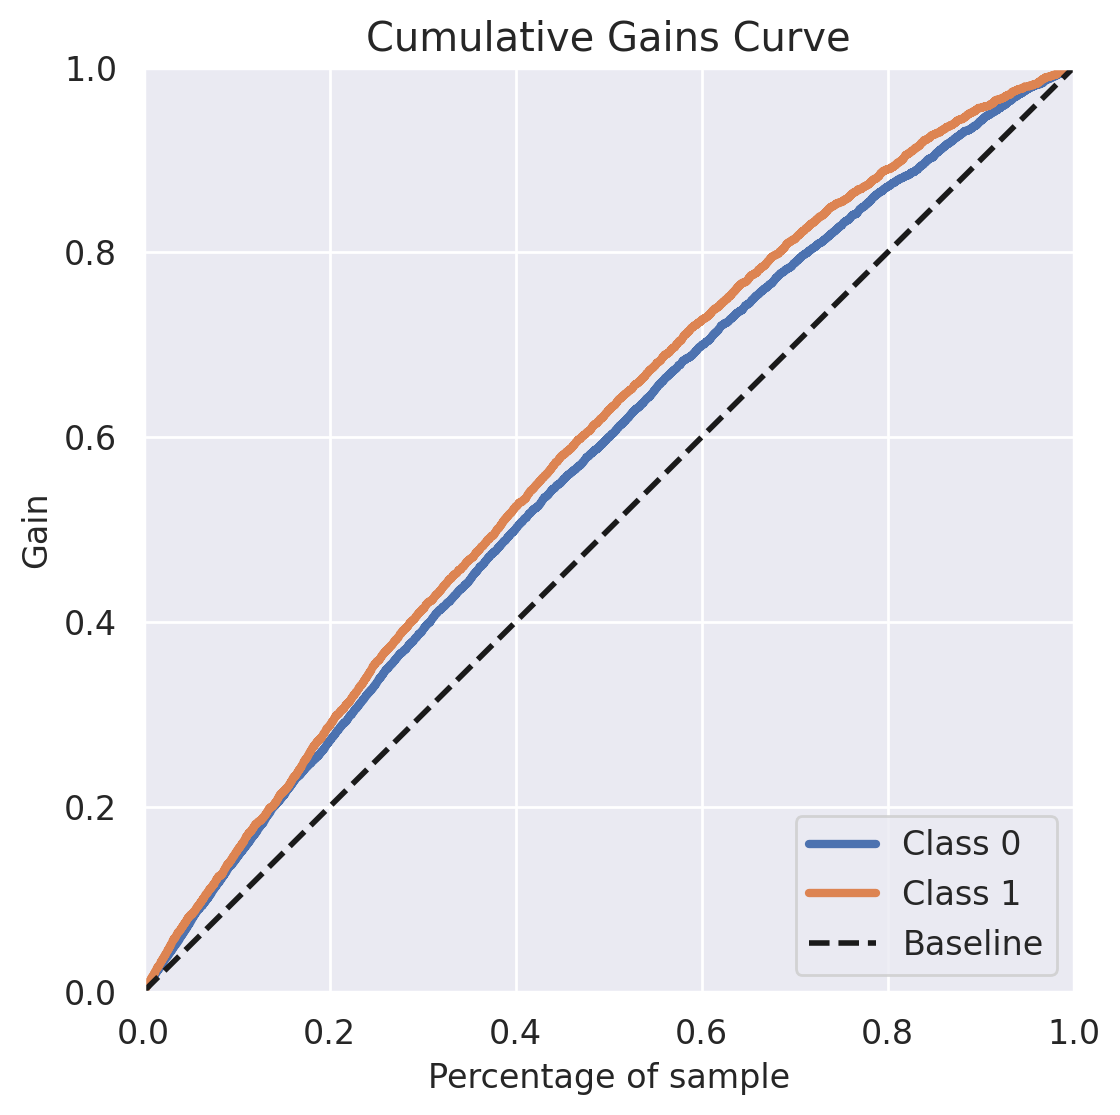

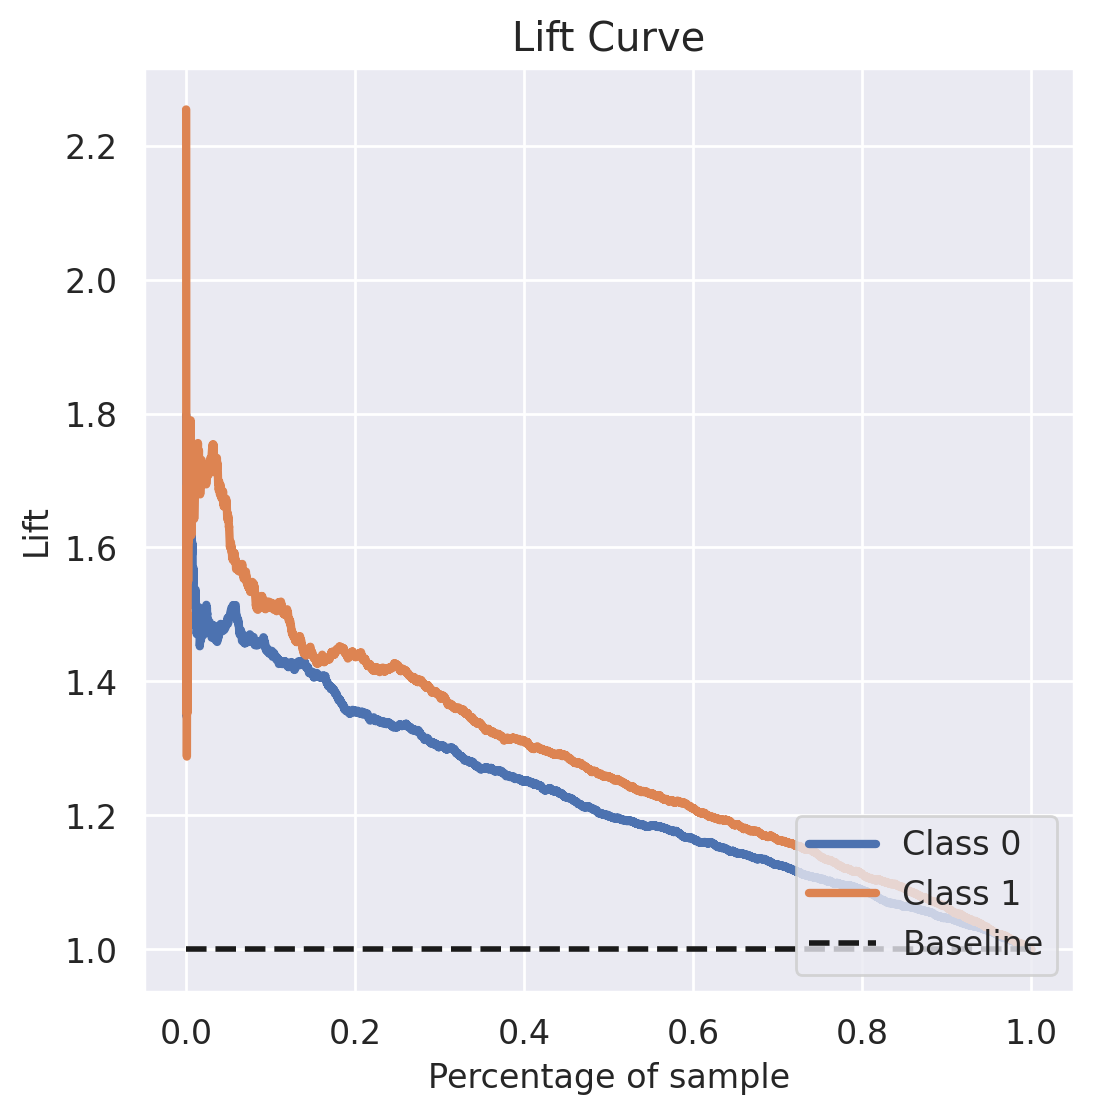

In [175]:
evaluationMetricsGCV(x_test, y_test, knn_model)